In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import time

import quflow as qf
from cupyx.profiler import benchmark

2023-06-30 11:50:09.469614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
qf.gpu.gpu_core.print_info()

CuPy version: 12.0.0
Device 0: b'NVIDIA GeForce GTX 1070':
	multiprocessor count: 15


Shown below is the execution time for different matrix size $N$ for both GPU and CPU, aswell as the respective speedup. The variables `time = 3.0`, `inner_time = 0.5` and
`qstepsize = 0.2` are fixed.

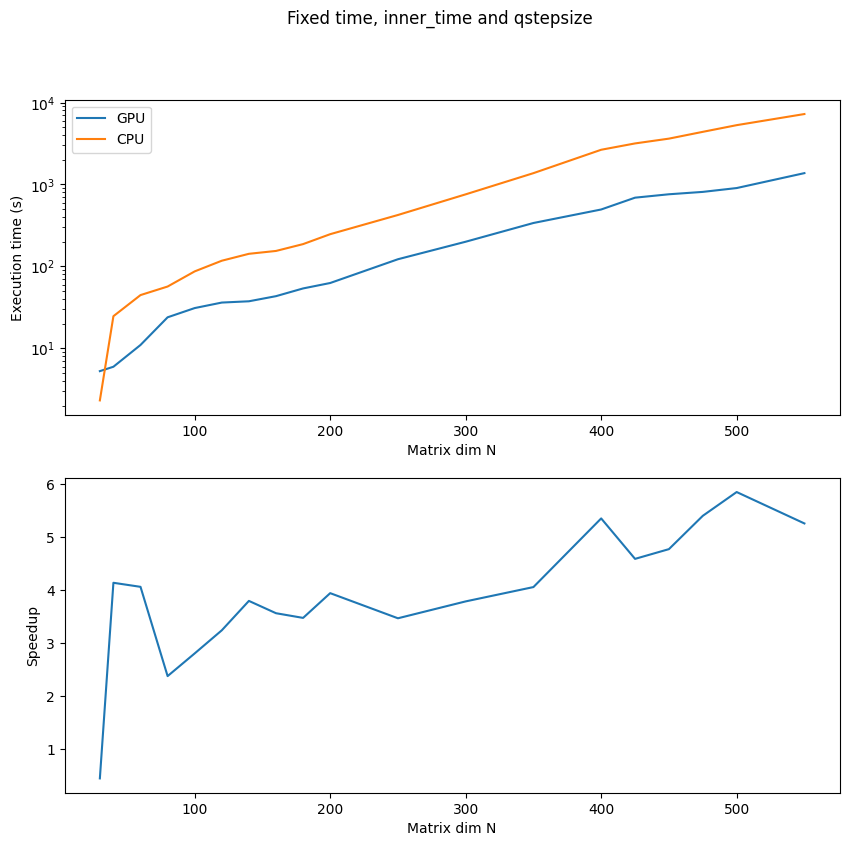

In [2]:
with open("speed_test2.json","r") as f:
    speed_data = json.load(f)


timings = np.array(speed_data["timings"])
n_samples = np.array(speed_data["n_samples"])

speedup = timings[1,:]/timings[0,:]

fig, ax = plt.subplots(2,1,figsize = (10,9))

fig.suptitle('Fixed time, inner_time and qstepsize')
# Execution time plot
ax[0].plot(n_samples,timings.T,label=["GPU","CPU"])

ax[0].set_yscale("log")
#ax[0].set_xscale("log")

ax[0].set_ylabel("Execution time (s)")
ax[0].set_xlabel("Matrix dim N")
ax[0].legend()

# Speedup plot

ax[1].plot(n_samples,speedup)

#ax[1].set_yscale("log")
#ax[1].set_xscale("log")

ax[1].set_ylabel("Speedup")
ax[1].set_xlabel("Matrix dim N")
#ax[1].legend()

plt.savefig("gpu_cpu_timings")

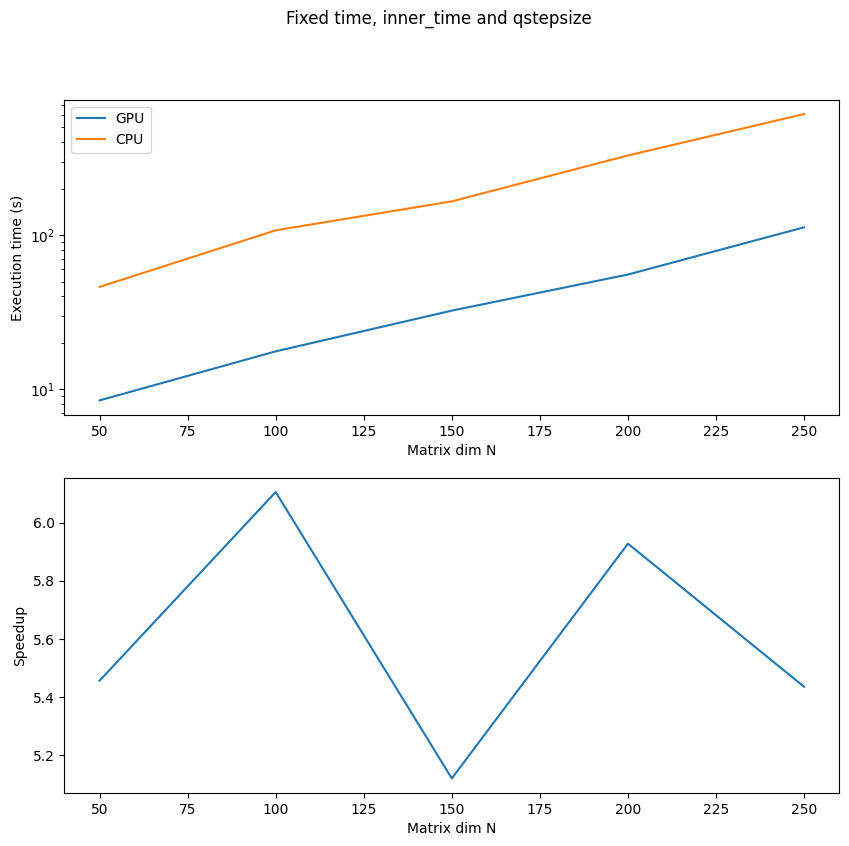

In [4]:
with open("speed_test_gpu.json","r") as f:
    speed_data = json.load(f)


timings = np.array(speed_data["timings"])
n_samples = np.array(speed_data["n_samples"])

speedup = timings[1,:]/timings[0,:]

fig, ax = plt.subplots(2,1,figsize = (10,9))

fig.suptitle('Fixed time, inner_time and qstepsize')
# Execution time plot
ax[0].plot(n_samples,timings.T,label=["GPU","CPU"])

ax[0].set_yscale("log")
#ax[0].set_xscale("log")

ax[0].set_ylabel("Execution time (s)")
ax[0].set_xlabel("Matrix dim N")
ax[0].legend()

# Speedup plot

ax[1].plot(n_samples,speedup)

#ax[1].set_yscale("log")
#ax[1].set_xscale("log")

ax[1].set_ylabel("Speedup")
ax[1].set_xlabel("Matrix dim N")
#ax[1].legend()

plt.savefig("gpu_cpu_timings")

In [2]:
def get_random_mat_cp(N=5,seed=None):
    if seed != None:
        cp.random.seed(seed)

    W = cp.random.randn(N, N) + 1j*cp.random.randn(N, N)
    W -= W.conj().T
    W -= cp.eye(N)*cp.trace(W)/N
    return W

def get_random_mat_np(N=5,seed=None):
    if seed != None:
        np.random.seed(seed)

    W = np.random.randn(N, N) + 1j*np.random.randn(N, N)
    W -= W.conj().T
    W -= np.eye(N)*np.trace(W)/N
    return W

def mult(A,B,C):
    cp.matmul(A,B,out=C)

Self made kernel with interleaved memory and caching underway:


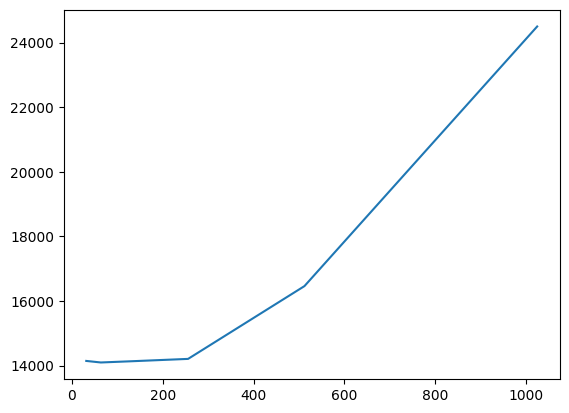

In [4]:
# ------- Testing block size for skew-herm cuThomas --------- #

N = 4096 # Size of matrices <---- Needs 
#N = 2048 # Size of matrix
n_repeat = 1000
n_repeat_cpu = 10

# Cupy arrays
W0_cp = get_random_mat_cp(N)

P0_c = cp.zeros_like(W0_cp)
ham_c = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)


block_size_samples = np.array([32,64,128,256,512,1024])
block_size_timings = np.zeros_like(block_size_samples)

print("Self made kernel with interleaved memory and caching underway:")
for (i,b_size) in enumerate(block_size_samples):
    block_size_timings[i] = benchmark(ham_c.solve_poisson,(W0_cp,P0_c,b_size),n_repeat=n_repeat).gpu_times[0].mean()*1e6


plt.figure()
plt.plot(block_size_samples,block_size_timings)
plt.show()


[[   665.79          117.87          286.53         2386.49
    4142.23         7683.05        13207.29        19329.79
   25940.39        33871.36        55403.48        86860.8
  105128.9       ]
 [   674.95849684    596.37350261    769.29004991   1215.49311978
    1678.70310354   2156.22518373   2695.75670791   3219.10765147
    3934.8040297    4743.1748786    6029.94568539   8126.19391537
    8780.86860561]
 [  1151.04787195    943.92832088   1061.8612482    1661.77964771
    2345.08258653   2970.52617812   3794.06511879   7078.02015638
    9419.98441505   8231.80518436  12710.08477688  17675.5662632
   25127.65343094]]


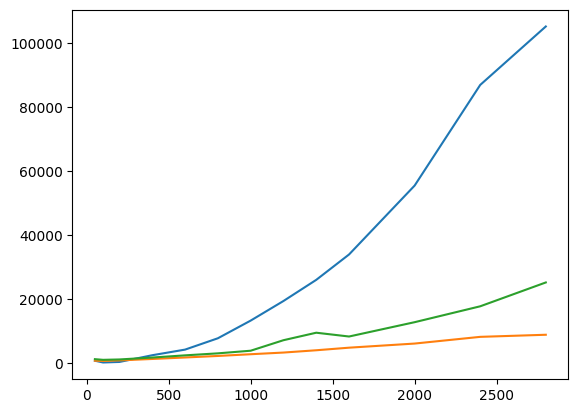

In [8]:
# ----------- comparing the different tridiagonal solvers ------- #

#N_samples = np.array([50,100,200,400,600,800,1000,1200,1400,1600,2000,2400,2800,3200,3600,4000]) # Size of matrices
N_samples = np.array([50,100,200,400,600,800,1000,1200,1400,1600,2000,2400,2800])
#N = 2048 # Size of matrix
n_repeat = 1000
n_repeat_cpu = 10

timings = np.zeros((3,len(N_samples)))

# Cupy arrays

for (i,N) in enumerate(N_samples):
    W0_cp = get_random_mat_cp(N)
    

    W0 = W0_cp.get()
    cpu_timing_total = 0
    for _ in range(n_repeat_cpu):
        cpu_timing_start = time.time_ns()
        P0 = qf.solve_poisson(W0)
        cpu_timing_total += (time.time_ns()-cpu_timing_start)/1e3
    timings[0,i] = cpu_timing_total / n_repeat_cpu
    del W0
    del P0


    P0_c = cp.zeros_like(W0_cp)
    ham_c = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)
    timings[1,i] = benchmark(ham_c.solve_poisson,(W0_cp,P0_c),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    del ham_c
    del P0_c

    P0_tf = cp.zeros_like(W0_cp)
    ham_tf = qf.gpu.gpu_tf.solve_poisson_cp(N)
    timings[2,i] = benchmark(ham_tf.solve_poisson,(W0_cp,P0_tf),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    del ham_tf
    del P0_tf

    del W0_cp

print(timings)

plt.figure()
plt.plot(N_samples,timings[0], label ="Interleaved less mem" )
plt.plot(N_samples,timings[1], label ="Interleaved" )
plt.plot(N_samples,timings[2], label ="Tf" )
plt.show()


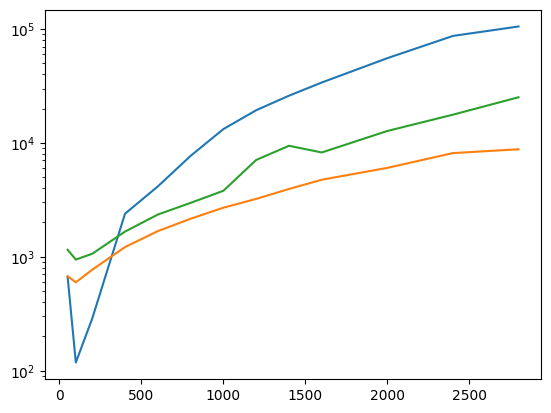

In [9]:
plt.figure()
plt.plot(N_samples,timings[0], label ="Interleaved less mem" )
plt.plot(N_samples,timings[1], label ="Interleaved" )
plt.plot(N_samples,timings[2], label ="Tf" )
plt.yscale("log")
plt.show()

[[  2539.125         835.831        9311.649       20449.439
   44682.661      112764.26       196191.702     ]
 [   766.32255033    569.73087892    907.91040659   3657.95936823
   10985.65279961  23243.33089828  43341.94274902]]


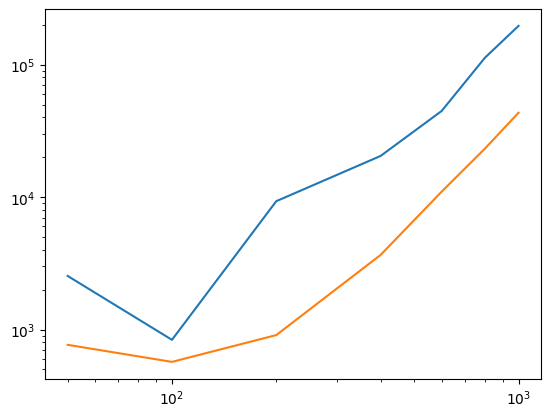

In [10]:
# ----------- matmul speed test ------- #

N_samples = np.array([50,100,200,400,600,800,1000,1200,1400,1600])
n_repeat = 100
n_repeat_cpu = 10

timings = np.zeros((2,len(N_samples)))

for (i,N) in enumerate(N_samples):
    A_cp = get_random_mat_cp(N,1)
    B_cp = get_random_mat_cp(N,2)
    C_cp = cp.empty_like(A_cp)

    A = A_cp.get()
    B = B_cp.get()
    C = np.zeros_like(B)
    cpu_timing_total = 0
    for _ in range(n_repeat_cpu):
        cpu_timing_start = time.time_ns()
        np.matmul(A, B, out=C)
        cpu_timing_total += (time.time_ns()-cpu_timing_start)
    timings[0,i] = cpu_timing_total / (n_repeat_cpu*1e3)


    timings[1,i] = benchmark(mult,(A_cp,B_cp,C_cp),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    
    del A
    del B
    del C

    del A_cp
    del B_cp
    del C_cp

print(timings)

plt.figure()
plt.plot(N_samples,timings[0])
plt.plot(N_samples,timings[1])
plt.yscale("log")
plt.xscale("log")
plt.show()

